In [216]:
import warnings
warnings.filterwarnings("ignore")
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
import pandas as pd

In [217]:
receivals = pd.read_csv("../data_cleaned/orders_with_receivals_detailed.csv", parse_dates=['date_arrival', 'delivery_date'])
# Filter out rows with missing rm_id or date_arrival
receivals = receivals[receivals['rm_id'].notnull() & receivals['date_arrival'].notnull()]
# date_arrival = actual date of receival, delivery_date = expected date of receival
# lead_time = date_arrival - delivery_date
# quantity  = quantity, net_weight = weight in kg (the actual target per day etc)
selected = receivals[["rm_id", "date_arrival", "net_weight", "supplier_id", "delivery_date", "product_id_receival", "quantity", "lead_time"]]
# Filter out the selected rows where rm_id is null or date_arrival is null
selected = selected[selected['rm_id'].notnull() & selected['date_arrival'].notnull()]

In [218]:
# CREATING TIME_IDX AND AGGREGATING TO DAILY LEVEL AND FILLING GAPS WITH 0 NET_WEIGHT RECEIVALS


# make a copy and normalize date_arrival to date-only (drop time) so grouping is by year-month-day
df_agg = selected.copy()
# ensure date_arrival is a datetime and floor to day (sets time to 00:00:00)
df_agg['date_arrival'] = df_agg['date_arrival'].dt.floor('D')
# Remove timezone info if present
df_agg['date_arrival'] = df_agg['date_arrival'].dt.tz_localize(None)

df_agg = df_agg.groupby(['rm_id', 'date_arrival']).agg({
    'net_weight': 'sum',
    'quantity': 'sum',
}).reset_index()

# Add time_idx based on days since each rm_id's minimum date
df_agg = df_agg.sort_values(['rm_id', 'date_arrival'])
df_agg['local_time_idx'] = (df_agg['date_arrival'] - df_agg.groupby('rm_id')['date_arrival'].transform('min')).dt.days

# Fill gaps from each rm_id's min date to 2024-12-31 with 0 net_weight entries
end_date = pd.Timestamp('2024-12-31')
all_filled = []

for rm_id, group in df_agg.groupby('rm_id'):
    min_date = group['date_arrival'].min()
    max_idx = (end_date - min_date).days
    
    full_range = pd.DataFrame({
        'local_time_idx': range(0, max_idx + 1)
    })
    full_range['rm_id'] = rm_id
    full_range['date_arrival'] = min_date + pd.to_timedelta(full_range['local_time_idx'], unit='D')
    
    merged = pd.merge(full_range, group, on=['rm_id', 'local_time_idx', 'date_arrival'], how='left')
    merged['net_weight'] = merged['net_weight'].fillna(0)
    merged['quantity'] = merged['quantity'].fillna(0)
  
    all_filled.append(merged)

df_agg = pd.concat(all_filled, ignore_index=True)
selected_with_local_time = df_agg

In [219]:
print(selected_with_local_time.where(selected_with_local_time["rm_id"]==2130).dropna()[["local_time_idx", "date_arrival", "net_weight"]].tail(2))

        local_time_idx date_arrival  net_weight
488659          4794.0   2024-12-30         0.0
488660          4795.0   2024-12-31         0.0


In [220]:
# Add additional features
selected_with_local_time["month"] = selected_with_local_time["date_arrival"].dt.month.astype(str).astype("category")
selected_with_local_time["year"] = selected_with_local_time["date_arrival"].dt.year.astype(str).astype("category")
selected_with_local_time["day_of_week"] = selected_with_local_time["date_arrival"].dt.dayofweek.astype(str).astype("category")  # 0=Monday, 6=Sunday
selected_with_local_time["log_weight"] = np.log1p(selected_with_local_time["net_weight"])

# Norwegian special days/holidays
# Fixed holidays
def get_norwegian_holidays(year):
    """Return dictionary of Norwegian holidays for a given year"""
    from datetime import timedelta
    
    holidays = {}
    
    # Fixed date holidays
    holidays[f'{year}-01-01'] = 'New Year'
    holidays[f'{year}-05-01'] = 'Labour Day'
    holidays[f'{year}-05-17'] = 'Constitution Day'
    holidays[f'{year}-12-24'] = 'Christmas Eve'
    holidays[f'{year}-12-25'] = 'Christmas Day'
    holidays[f'{year}-12-26'] = 'Boxing Day'
    holidays[f'{year}-12-31'] = 'New Year Eve'
    
    # Easter-based holidays (Easter dates vary each year)
    # Approximate Easter calculation (Meeus/Jones/Butcher algorithm)
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    month = (h + l - 7 * m + 114) // 31
    day = ((h + l - 7 * m + 114) % 31) + 1
    
    easter = pd.Timestamp(year=year, month=month, day=day)
    
    # Easter-related holidays
    holidays[(easter - timedelta(days=3)).strftime('%Y-%m-%d')] = 'Maundy Thursday'
    holidays[(easter - timedelta(days=2)).strftime('%Y-%m-%d')] = 'Good Friday'
    holidays[easter.strftime('%Y-%m-%d')] = 'Easter Sunday'
    holidays[(easter + timedelta(days=1)).strftime('%Y-%m-%d')] = 'Easter Monday'
    holidays[(easter + timedelta(days=39)).strftime('%Y-%m-%d')] = 'Ascension Day'
    holidays[(easter + timedelta(days=49)).strftime('%Y-%m-%d')] = 'Whit Sunday'
    holidays[(easter + timedelta(days=50)).strftime('%Y-%m-%d')] = 'Whit Monday'
    
    return holidays

# Create a mapping of all dates to holidays
all_holidays = {}
for year in range(selected_with_local_time['date_arrival'].dt.year.min(), 
                  selected_with_local_time['date_arrival'].dt.year.max() + 1):
    all_holidays.update(get_norwegian_holidays(year))

# Add special day column
selected_with_local_time['date_str'] = selected_with_local_time['date_arrival'].dt.strftime('%Y-%m-%d')
selected_with_local_time['special_days'] = selected_with_local_time['date_str'].map(all_holidays).fillna('none').astype('category')
selected_with_local_time.drop('date_str', axis=1, inplace=True)

# Add binary flag for whether it's a holiday
selected_with_local_time['is_holiday'] = (selected_with_local_time['special_days'] != 'none').astype(int)

In [221]:
print(selected_with_local_time.where(selected_with_local_time["rm_id"]==2130).dropna().tail(2))


        local_time_idx   rm_id date_arrival  net_weight  quantity month  year  \
488659          4794.0  2130.0   2024-12-30         0.0       0.0    12  2024   
488660          4795.0  2130.0   2024-12-31         0.0       0.0    12  2024   

       day_of_week  log_weight  special_days  is_holiday  
488659           0         0.0          none         0.0  
488660           1         0.0  New Year Eve         1.0  


In [222]:
special_days = list(all_holidays.values())

# Make rm_id a string instead of numeric
selected_with_local_time["rm_id"] = selected_with_local_time["rm_id"].astype(str).astype("category")
selected_with_local_time["is_holiday"] = selected_with_local_time["is_holiday"].astype(str).astype("category")

In [223]:
full_data = selected_with_local_time.copy()

max_prediction_length = 365
max_encoder_length = 24
# V: training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    # V: data[lambda x: x.local_time_idx <= training_cutoff],
    data = full_data,
    time_idx="local_time_idx",
    target="net_weight",
    group_ids=["rm_id"],
    min_encoder_length=max_encoder_length
    // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["rm_id"],
    #static_reals= no static real yet,
    time_varying_known_categoricals=["special_days", "month", "day_of_week", "is_holiday"],
    #variable_groups={
    #    "special_days": special_days
    #},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["local_time_idx"],
    # CAN PUT YEAR IN TIME_VARYING_KNOWN_REALS
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "quantity",
        "net_weight",
        "log_weight",
    ],
    target_normalizer=GroupNormalizer(
        groups=["rm_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
#V: validation = TimeSeriesDataSet.from_dataset(
#V:    training, data, predict=True, stop_randomization=True
#V:)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
#V: val_dataloader = validation.to_dataloader(
#V:    train=False, batch_size=batch_size * 10, num_workers=0

In [224]:
# TRAINING THE MODEL
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    #fast_dev_run = True,
    callbacks=[lr_logger],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.01,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    #optimizer="ranger", OPTIMIZER FOR FINDING BEST LEARNING RATE
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 10.5k


In [225]:
# YOU SHOULD DO THIS CAUSE THE OPTIMAL
# LEARNING RATE PYTORCH LIGHTNING COULD
# SOMETIMES BE CONFUSED BY THE NOISE AT LOWER LEARNING RATES
# AND SUGGESTS RATES FAR TOO LOW. MANUAL CONTROL IS ESSENTIAL
# # find optimal learning rate
# from lightning.pytorch.tuner import Tuner

# res = Tuner(trainer).lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [226]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.8 K  | train
3  | prescalers                         | ModuleDict                      | 128    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.5 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304    

Epoch 49: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s, v_num=2, train_loss_step=560.0, train_loss_epoch=634.0]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s, v_num=2, train_loss_step=560.0, train_loss_epoch=634.0]


In [264]:
test_rm_id = "2130.0"  # Must be string since we converted rm_id to string

# Get the historical data for this rm_id to know the min_date and last time_idx
historical = full_data[full_data['rm_id'] == test_rm_id].copy()
min_date = historical['date_arrival'].min()
last_time_idx = historical['local_time_idx'].max()

# Create prediction date range
pred_start = pd.Timestamp('2025-01-01')
pred_end = pd.Timestamp('2025-05-31')
pred_dates = pd.date_range(start=pred_start, end=pred_end, freq='D')

# Build prediction dataframe
predict_data = []
for date in pred_dates:
    time_idx = (date - min_date).days
    
    # Get Norwegian holidays for this date
    date_str = date.strftime('%Y-%m-%d')
    special_day = all_holidays.get(date_str, 'none')
    is_holiday = '1' if special_day != 'none' else '0'
    
    predict_data.append({
        'rm_id': test_rm_id,
        'date_arrival': date,
        'local_time_idx': time_idx,
        'month': str(date.month),
        'day_of_week': str(date.dayofweek),
        'special_days': special_day,
        'is_holiday': is_holiday,
        'net_weight': 0,  # placeholder
        'quantity': 0,  # placeholder
        'log_weight': 0  # placeholder
    })

predict_df = pd.DataFrame(predict_data)

# Convert to categorical to match training data
predict_df['rm_id'] = predict_df['rm_id'].astype(str).astype('category')
predict_df['month'] = predict_df['month'].astype(str).astype('category')
predict_df['day_of_week'] = predict_df['day_of_week'].astype(str).astype('category')
predict_df['special_days'] = predict_df['special_days'].astype(str).astype('category')
predict_df['is_holiday'] = predict_df['is_holiday'].astype(str).astype('category')

# CRITICAL: Ensure local_time_idx is integer (required by TimeSeriesDataSet)
predict_df['local_time_idx'] = predict_df['local_time_idx'].astype(int)

print(f"Prediction dataframe shape: {predict_df.shape}")
print(f"Date range: {predict_df['date_arrival'].min()} to {predict_df['date_arrival'].max()}")
print(f"Time index range: {predict_df['local_time_idx'].min()} to {predict_df['local_time_idx'].max()}")
print("\nFirst few rows:")
print(predict_df.head())

# Combine historical + prediction data for the model
# The model needs context (encoder) from historical data
encoder_data = historical.tail(max_encoder_length).copy()  # Last 24 days as context
# Ensure encoder data also has integer time_idx
#encoder_data = encoder_data.drop("year", axis=1)
encoder_data['local_time_idx'] = encoder_data['local_time_idx'].astype(int)
full_predict_data = pd.concat([encoder_data, predict_df], ignore_index=True)

Prediction dataframe shape: (151, 10)
Date range: 2025-01-01 00:00:00 to 2025-05-31 00:00:00
Time index range: 4796 to 4946

First few rows:
    rm_id date_arrival  local_time_idx month day_of_week special_days  \
0  2130.0   2025-01-01            4796     1           2         none   
1  2130.0   2025-01-02            4797     1           3         none   
2  2130.0   2025-01-03            4798     1           4         none   
3  2130.0   2025-01-04            4799     1           5         none   
4  2130.0   2025-01-05            4800     1           6         none   

  is_holiday  net_weight  quantity  log_weight  
0          0           0         0           0  
1          0           0         0           0  
2          0           0         0           0  
3          0           0         0           0  
4          0           0         0           0  


In [257]:
# Make predictions using the trained model
predictions = tft.predict(full_predict_data, mode="raw", return_x=True)

print(f"\nPredictions shape: {predictions.output.prediction.shape}")
print(f"Predictions (first 10 days):")
print(predictions.output.prediction[:10, :, 3])  # [:10 samples, :all time steps, 3=median quantile]

AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [266]:
pred_data_set = TimeSeriesDataSet.from_dataset(
    training,
    full_predict_data,
    predict=True,
    stop_randomization=True
)

AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


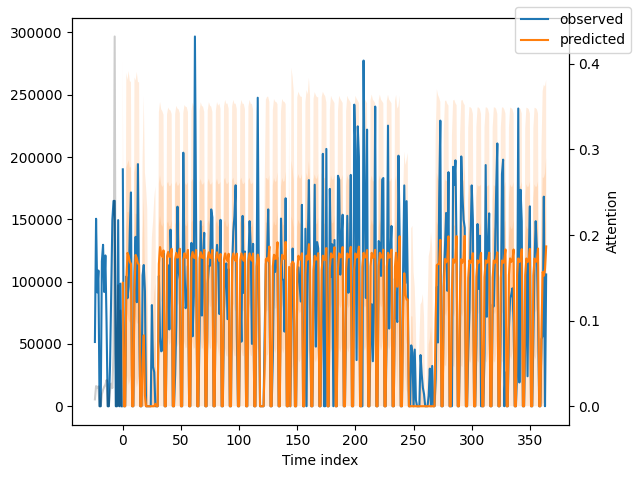

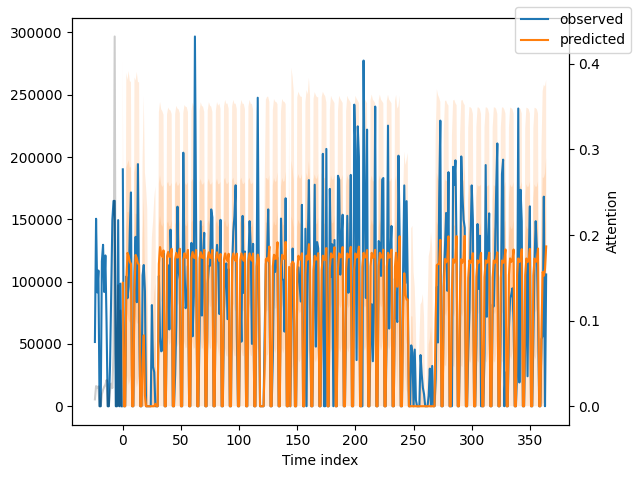

In [280]:
raw_prediction = tft.predict(
    training.filter(
        lambda x: (x.rm_id == "2130.0")
    ),
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)
tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [265]:
print(full_predict_data.head(0))
print(historical.head(0))
print(predict_df.head(0))

Empty DataFrame
Columns: [local_time_idx, rm_id, date_arrival, net_weight, quantity, month, year, day_of_week, log_weight, special_days, is_holiday]
Index: []
Empty DataFrame
Columns: [local_time_idx, rm_id, date_arrival, net_weight, quantity, month, year, day_of_week, log_weight, special_days, is_holiday]
Index: []
Empty DataFrame
Columns: [rm_id, date_arrival, local_time_idx, month, day_of_week, special_days, is_holiday, net_weight, quantity, log_weight]
Index: []


In [267]:
print(full_data.head(0))

Empty DataFrame
Columns: [local_time_idx, rm_id, date_arrival, net_weight, quantity, month, year, day_of_week, log_weight, special_days, is_holiday]
Index: []


In [211]:
# Get rows for the first rm_id in the dataset
first_rm_id = full_data["rm_id"].iloc[0]  # Extract the actual value
specific_rm = full_data[full_data["rm_id"] == first_rm_id]

print(first_rm_id)
print(str(float(2)) == str(2))

342.0
False


In [214]:
specific_rm = full_data[full_data["rm_id"] == "2130.0"]
print(specific_rm)

        local_time_idx   rm_id date_arrival  net_weight   quantity month  \
483865               0  2130.0   2011-11-15     51540.0   497000.0    11   
483866               1  2130.0   2011-11-16    150454.0  1930000.0    11   
483867               2  2130.0   2011-11-17     91344.0  1906000.0    11   
483868               3  2130.0   2011-11-18    108900.0  1371000.0    11   
483869               4  2130.0   2011-11-19         0.0        0.0    11   
...                ...     ...          ...         ...        ...   ...   
488656            4791  2130.0   2024-12-27         0.0        0.0    12   
488657            4792  2130.0   2024-12-28         0.0        0.0    12   
488658            4793  2130.0   2024-12-29         0.0        0.0    12   
488659            4794  2130.0   2024-12-30         0.0        0.0    12   
488660            4795  2130.0   2024-12-31         0.0        0.0    12   

        year day_of_week  log_weight  special_days is_holiday  
483865  2011           

In [ ]:
#rm_id, local_time_idx, net_weight, special_days, month, day_of_week, is_holiday, quantity, log_weight